In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-01-31 01:40:45--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-01-31 01:40:45--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  95.5MB/s    in 2.5s    

2025-01-31 01:40:48 (95.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os, glob
from torchvision.io import read_image, ImageReadMode

batch_size = 64

id_dict = {}
for i, line in enumerate(open('/content/tiny-imagenet-200/wnids.txt', 'r')):
  id_dict[line.replace('\n', '')] = i

class TrainTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob("/content/tiny-imagenet-200/train/*/*/*.JPEG")
        self.transform = transform
        self.id_dict = id

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:
          image = read_image(img_path,ImageReadMode.RGB)
        label = self.id_dict[img_path.split('/')[4]]
        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label

class TestTinyImageNetDataset(Dataset):
    def __init__(self, id, transform=None):
        self.filenames = glob.glob("/content/tiny-imagenet-200/val/images/*.JPEG")
        self.transform = transform
        self.id_dict = id
        self.cls_dic = {}
        for i, line in enumerate(open('/content/tiny-imagenet-200/val/val_annotations.txt', 'r')):
            a = line.split('\t')
            img, cls_id = a[0],a[1]
            self.cls_dic[img] = self.id_dict[cls_id]


    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = self.filenames[idx]
        image = read_image(img_path)
        if image.shape[0] == 1:
          image = read_image(img_path,ImageReadMode.RGB)
        label = self.cls_dic[img_path.split('/')[-1]]
        if self.transform:
            image = self.transform(image.type(torch.FloatTensor))
        return image, label

transform = None

trainset = TrainTinyImageNetDataset(id=id_dict, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = TestTinyImageNetDataset(id=id_dict, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

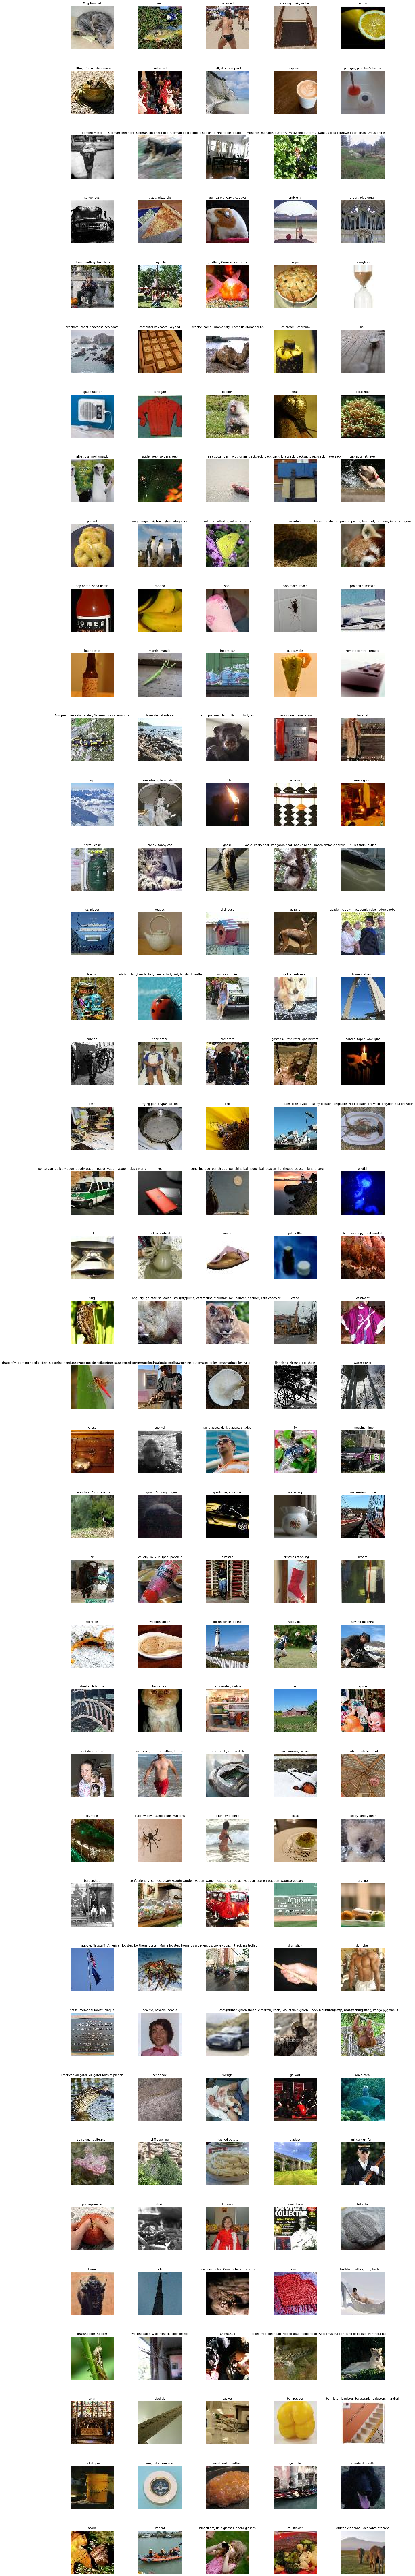

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Load class names from words.txt
class_names = {}
with open('/content/tiny-imagenet-200/words.txt', 'r') as f:
    for line in f:
        class_id, class_name = line.strip().split('\t')
        class_names[class_id] = class_name

def show_one_image_per_class(dataset, id_dict, class_names):
    class_images = {class_id: None for class_id in id_dict.values()}
    class_labels = {class_id: None for class_id in id_dict.values()}

    for image, label in dataset:
        if class_images[label] is None:
            class_images[label] = image
            class_labels[label] = list(id_dict.keys())[list(id_dict.values()).index(label)]  # Get class ID from label
        if all(img is not None for img in class_images.values()):
            break

    # Plot one image from each class
    num_classes = len(class_images)
    num_rows = (num_classes + 4) // 5  # Calculate number of rows needed (5 images per row)
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))  # Adjust figsize for better visibility
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between images

    for i, (class_id, img) in enumerate(class_images.items()):
        ax = axes[i // 5, i % 5] if num_rows > 1 else axes[i % 5]  # Handle single row case
        ax.axis('off')

        # Get class name from class ID
        class_id_str = class_labels[class_id]
        class_name = class_names.get(class_id_str, "Unknown")

        ax.set_title(class_name, fontsize=10)  # Adjust font size for better readability
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Display image without unnormalization

    # Hide empty subplots if any
    for j in range(i + 1, num_rows * 5):
        if num_rows > 1:
            axes[j // 5, j % 5].axis('off')
        else:
            axes[j % 5].axis('off')

    plt.show()

# Call the function to display one image per class with class names
show_one_image_per_class(trainset, id_dict, class_names)

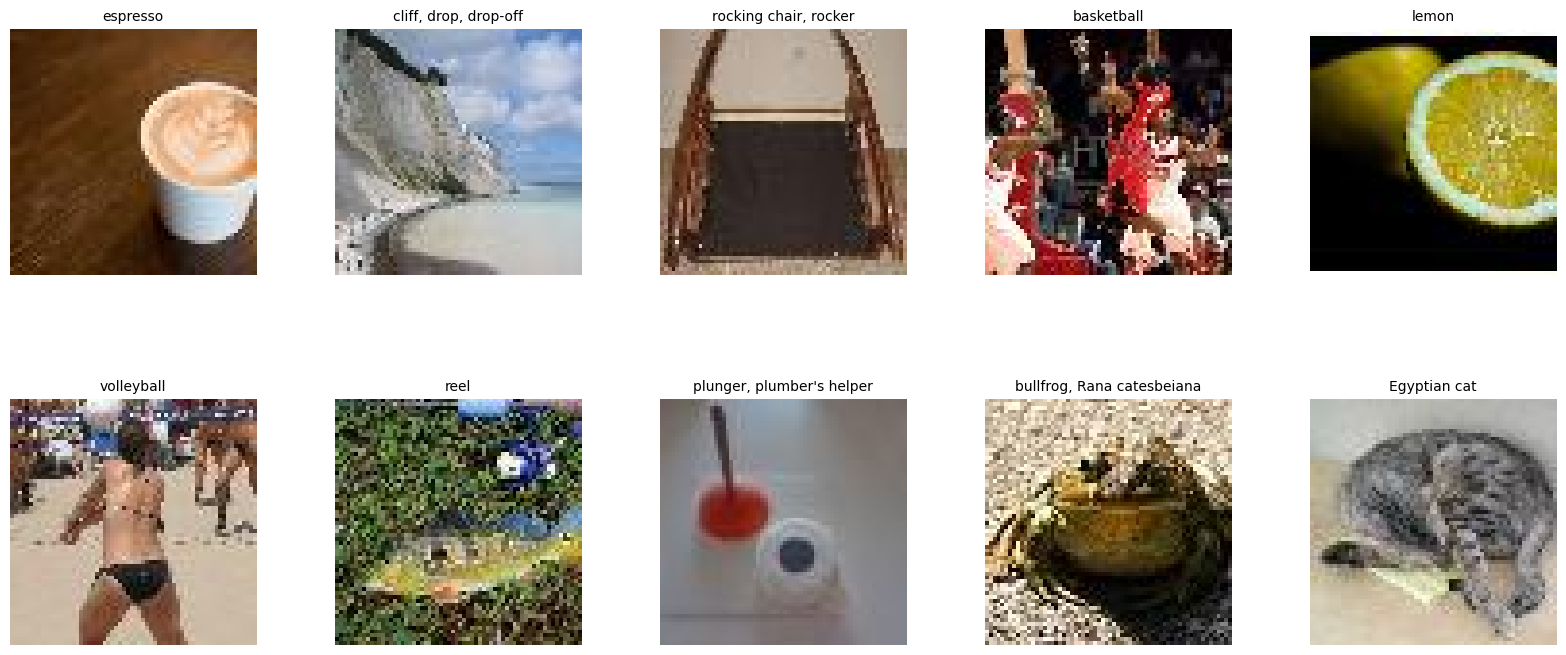

In [12]:
def show_one_image_per_class(dataset, id_dict, class_names, num_classes=10):
    class_images = {}
    class_labels = {}

    # Batasi hanya 10 kelas pertama
    selected_classes = list(id_dict.values())[:num_classes]

    for image, label in dataset:
        if label in selected_classes and label not in class_images:
            class_images[label] = image
            class_labels[label] = list(id_dict.keys())[list(id_dict.values()).index(label)]  # Get class ID from label
        if len(class_images) == num_classes:
            break

    # Plot one image from each selected class
    num_rows = (num_classes + 4) // 5  # Calculate number of rows needed (5 images per row)
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows * 4))  # Adjust figsize for better visibility
    fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between images

    for i, (class_id, img) in enumerate(class_images.items()):
        ax = axes[i // 5, i % 5] if num_rows > 1 else axes[i % 5]  # Handle single row case
        ax.axis('off')

        # Get class name from class ID
        class_id_str = class_labels[class_id]
        class_name = class_names.get(class_id_str, "Unknown")

        ax.set_title(class_name, fontsize=10)  # Adjust font size for better readability
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Display image without unnormalization

    # Hide empty subplots if any
    for j in range(i + 1, num_rows * 5):
        if num_rows > 1:
            axes[j // 5, j % 5].axis('off')
        else:
            axes[j % 5].axis('off')

    plt.show()

# Call the function to display one image per class with class names (only 10 classes)
show_one_image_per_class(trainset, id_dict, class_names, num_classes=10)

In [11]:
import os
from PIL import Image

def save_one_image_per_class(dataset, id_dict, class_names, save_dir='images'):
    os.makedirs(save_dir, exist_ok=True)
    class_images = {class_id: None for class_id in id_dict.values()}
    class_labels = {class_id: None for class_id in id_dict.values()}

    for image, label in dataset:
        if class_images[label] is None:
            class_images[label] = image
            class_labels[label] = list(id_dict.keys())[list(id_dict.values()).index(label)]  # Get class ID from label
        if all(img is not None for img in class_images.values()):
            break

    for class_id, img in class_images.items():
        class_id_str = class_labels[class_id]
        class_name = class_names.get(class_id_str, "Unknown")
        img_pil = transforms.ToPILImage()(img)
        img_pil.save(os.path.join(save_dir, f'{class_name}.png'))

# Call the function to save one image per class
save_one_image_per_class(trainset, id_dict, class_names)

In [13]:
def save_one_image_per_class(dataset, id_dict, class_names, save_dir='images_2', num_classes=10):
    os.makedirs(save_dir, exist_ok=True)
    class_images = {}
    class_labels = {}

    # Batasi hanya 10 kelas pertama
    selected_classes = list(id_dict.values())[:num_classes]

    for image, label in dataset:
        if label in selected_classes and label not in class_images:
            class_images[label] = image
            class_labels[label] = list(id_dict.keys())[list(id_dict.values()).index(label)]  # Get class ID from label
        if len(class_images) == num_classes:
            break

    for class_id, img in class_images.items():
        class_id_str = class_labels[class_id]
        class_name = class_names.get(class_id_str, "Unknown")
        img_pil = transforms.ToPILImage()(img)
        img_pil.save(os.path.join(save_dir, f'{class_name}.png'))

# Call the function to save one image per class (only 10 classes)
save_one_image_per_class(trainset, id_dict, class_names, num_classes=10)